In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path

# Path to your facility summary CSV file
file_path = "../data/raw/2021_NEI_Facility_summary.csv"  

print(f"Reading data from {file_path}...")

# Create output directory if it doesn't exist
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file - automatically detect the delimiter
try:
    df = pd.read_csv(file_path, sep=',', low_memory=False)
    print("File read with tab delimiter")
except:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print("File read with comma delimiter")
    except:
        df = pd.read_csv(file_path, sep=None, engine='python', low_memory=False)
        print(f"File read with automatic delimiter detection")

print(f"Data loaded. Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Reading data from ../data/raw/2021_NEI_Facility_summary.csv...
File read with tab delimiter
Data loaded. Shape: (2005169, 33)
Columns: ['state', 'fips state code', 'tribal name', 'fips code', 'county', 'eis facility id', 'program system code', 'agency facility id', 'tri facility id', 'company name', 'site name', 'primary naics code', 'primary naics description', 'facility source type', 'site latitude', 'site longitude', 'address', 'city', 'zip code', 'postal abbreviation', 'reporting period', 'emissions operating type', 'pollutant code', 'pollutant desc', 'pollutant type(s)', 'hap type', 'total emissions', 'emissions uom', 'data set', 'outlier minimum', 'outlier maximum', 'outlier?', 'national maximum']


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ================================
# Step 1: Load & Process Emissions Data
# ================================

print("Aggregating emissions by facility and pollutant category...")

# Ensure latitude and longitude exist before creating geometry
df['geometry'] = df.apply(lambda row: Point(row['site longitude'], row['site latitude']), axis=1)

# Convert emissions to metric tonnes
def convert_to_tonnes(row):
    if row['emissions uom'] == 'LB':
        return float(row['total emissions']) * 0.000453592  # Convert pounds to metric tonnes
    elif row['emissions uom'] == 'TON':
        return float(row['total emissions']) * 0.90718474  # Convert short tons to metric tonnes
    return float(row['total emissions'])  # Already in metric tonnes

df['emissions_tonnes'] = df.apply(convert_to_tonnes, axis=1)

# Categorize pollutants
def categorize_pollutant(row):
    pollutant = str(row['pollutant code']).upper()
    pollutant_desc = str(row['pollutant desc']).upper()

    if pollutant == 'VOC' or 'VOLATILE ORGANIC' in pollutant_desc:
        return 'VOC'
    elif pollutant in ['NOX', 'NO', 'NO2'] or ('NITROGEN' in pollutant_desc and 'OXIDE' in pollutant_desc):
        return 'NOx'
    elif pollutant == 'NH3' or 'AMMONIA' in pollutant_desc:
        return 'NH3'
    elif pollutant in ['SO2', 'SO4'] or 'SULFUR' in pollutant_desc:
        return 'SOx'
    elif 'PM25' in pollutant or 'PM2.5' in pollutant_desc or 'PM2_5' in pollutant:
        return 'PM2_5'
    return 'Other'

df['pollutant_category'] = df.apply(categorize_pollutant, axis=1)

# Filter out Alaska & Hawaii
df = df[~df['state'].isin(['AK', 'HI'])]

# ================================
# Step 2: Aggregate Data by Facility
# ================================

facility_emissions = df.groupby([
    'eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
    'primary naics code', 'primary naics description', 'pollutant_category'
])['emissions_tonnes'].sum().reset_index()

# Convert to wide format with pollutants as columns
facility_wide = facility_emissions.pivot_table(
    index=['eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
           'primary naics code', 'primary naics description'],
    columns='pollutant_category', 
    values='emissions_tonnes',
    fill_value=0
).reset_index()

# Ensure all required pollutant columns exist
for cat in ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']:
    if cat not in facility_wide.columns:
        facility_wide[cat] = 0

# ================================
# Step 3: Create GeoDataFrame & Filter Power Plants
# ================================

print("Creating GeoDataFrame...")
facility_wide['geometry'] = facility_wide.apply(lambda row: Point(row['site longitude'], row['site latitude']), axis=1)

gdf = gpd.GeoDataFrame(
    facility_wide, 
    geometry='geometry',
    crs='epsg:4269'  # Set coordinate reference system
)

# Filter for power plants (EGUs) using NAICS codes
egu_naics = ['2211', '221111', '221112', '221113', '221114', '221115', '221116', '221117', '221118']
egu_gdf = gdf[gdf['primary naics code'].astype(str).str.startswith(tuple(egu_naics))]

print(f"Found {len(egu_gdf)} power plant facilities (in the lower 48 states)")

# ================================
# Step 4: Save Processed Data
# ================================

output_dir = "../data/processed"  # Change this to your output folder

egu_output_file = f"{output_dir}/processed_2022_egu_emissions.gpkg"
egu_gdf.to_file(egu_output_file, driver="GPKG")
print(f"Saved processed power plant data to {egu_output_file}")

# Save all facilities data
all_facilities_output = f"{output_dir}/processed_2022_all_facilities_emissions.gpkg"
gdf.to_file(all_facilities_output, driver="GPKG")
print(f"Saved all facilities data to {all_facilities_output}")

# ================================
# Step 5: Generate Industry Summary
# ================================

print("\nGenerating summary by industry type...")

industry_summary = gdf.groupby('primary naics description').agg({
    'VOC': 'sum',
    'NOx': 'sum',
    'NH3': 'sum',
    'SOx': 'sum',
    'PM2_5': 'sum',
    'eis facility id': 'count'
}).reset_index()

industry_summary = industry_summary.rename(columns={'eis facility id': 'facility_count'})
industry_summary = industry_summary.sort_values('NOx', ascending=False)

# Save industry summary to CSV
industry_summary_file = f"{output_dir}/industry_emissions_summary.csv"
industry_summary.to_csv(industry_summary_file, index=False)
print(f"Saved industry summary to {industry_summary_file}")

print("\nProcessing complete!")


Aggregating emissions by facility and pollutant category...
Creating GeoDataFrame...
Found 2628 power plant facilities (in the lower 48 states)
Saved processed power plant data to ../data/processed/processed_2022_egu_emissions.gpkg
Saved all facilities data to ../data/processed/processed_2022_all_facilities_emissions.gpkg

Generating summary by industry type...
Saved industry summary to ../data/processed/industry_emissions_summary.csv

Processing complete!


In [6]:
egu_gdf[egu_gdf.state  == 'CA'].to_csv('og_NEI_CA.csv')

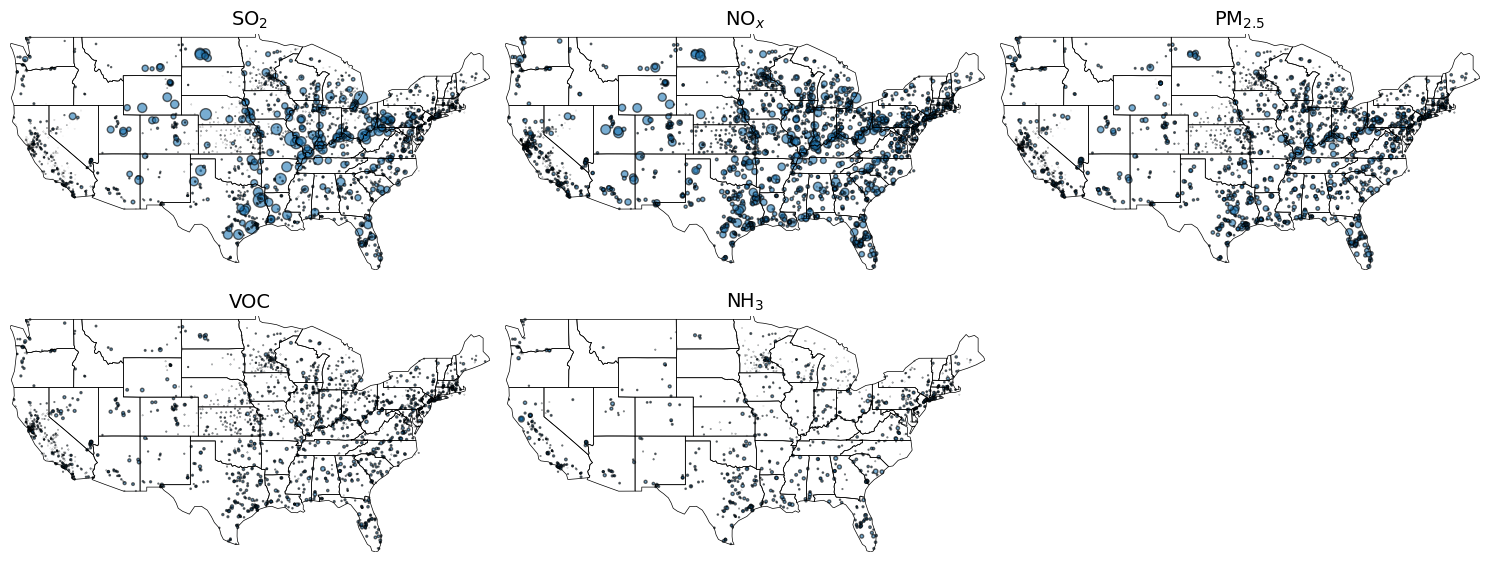

In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# 1. Load & Convert CRS
us_states = gpd.read_file("../data/raw/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
us_states = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]
us_states = us_states.to_crs(epsg=4269)  # match egu_gdf if egu_gdf is in EPSG:4269

egu_gdf = egu_gdf.to_crs(epsg=4269)     # ensure egu_gdf also in EPSG:4269

# 2. Pollutants
pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

# 3. Plot
fig, axes = plt.subplots(figsize=(15, 6), nrows=2, ncols=3, sharex=True, sharey=True)
#plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.01, hspace=0.01)

minx, miny, maxx, maxy = us_states.total_bounds

for i, ax in enumerate(axes.flat):
    if i < len(pols):
        us_states.boundary.plot(ax=ax, color="black", linewidth=0.5)
        egu_gdf.plot(
            ax=ax,
            markersize=egu_gdf[pols[i]]**0.5 / 2,
            alpha=0.6,
            edgecolor='black'
        )
        ax.set_title(pol_names[i], fontsize=14)
        
        # Zoom to lower 48
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

# 4. Remove the last unused subplot
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

In [18]:
# Below are the helper functions for the run_sr function
import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs

def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

# Define the run_sr function
def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    
    # Load spatial receptor grid (SR)
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={"region_name": "us-east-2"})
    sr = zarr.open(
        store=url,
        mode="r",
        storage_options={"anon": True, "client_kwargs": {"region_name": "us-east-2"}}
    )   

    # Build the grid geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # Create grid GeoDataFrame
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p, crs="+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1")
    
    # Ensure emis has CRS set correctly
    if emis.crs is None:
        print("Warning: emis CRS is None. Assigning default CRS (WGS84).")
        emis = emis.set_crs("EPSG:4326")

    # Convert emissions to match grid CRS
    emis = emis.to_crs(gdf.crs)

    # Spatial join (match emissions to grid)
    join_right_df = gdf.sjoin(emis, how="right")

    # Debugging: Print missing locations
    missing_count = join_right_df.Location.isna().sum()
    print(f"Finished joining dataframes. Missing locations: {missing_count}")

    # Drop NaN locations if any exist
    join_right_df = join_right_df.dropna(subset=["Location"])
    
    index = join_right_df.Location.astype(int).tolist()  # Ensure integer type

    # Get unique indices for emissions
    ppl = np.unique(index).tolist()

    # Create dictionary for mapping locations to index
    dictionary = {ppl[i]: i for i in range(len(ppl))}

    # Load Source-Receptor (SR) matrix data
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data allocated.")

    # Initialize output data arrays
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0

    # Calculate pollution data using emissions
    for i in range(len(index)):
        loc_idx = dictionary[index[i]]  # Get correct index
        SOA_data += SOA[0, loc_idx, :] * emis.VOC.iloc[i]
        pNO3_data += pNO3[0, loc_idx, :] * emis.NOx.iloc[i]
        pNH4_data += pNH4[0, loc_idx, :] * emis.NH3.iloc[i]
        pSO4_data += pSO4[0, loc_idx, :] * emis.SOx.iloc[i]
        PM25_data += PM25[0, loc_idx, :] * emis.PM2_5.iloc[i]

    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing data.")

    # Apply emission unit conversion factor
    fact = 28766.639 if emis_units == "tons/year" else 1

    # Compute final pollution metrics
    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523

    # Create output GeoDataFrame
    ret = gpd.GeoDataFrame(pd.DataFrame({
        'SOA': fact * SOA_data,
        'pNO3': fact * pNO3_data,
        'pNH4': fact * pNH4_data,
        'pSO4': fact * pSO4_data,
        'PrimaryPM25': fact * PM25_data,
        'TotalPM25': TotalPM25,
        'deathsK': deathsK,
        'deathsL': deathsL
    }), geometry=p[:52411])

    print(f"Finished ({time.time() - start:.0f} seconds)")
    return ret

# Run the function
resultsISRM = run_sr(egu_gdf, model="isrm", emis_units="tons/year")

Making polygons as geometry.
Finished joining dataframes. Missing locations: 15
SOA data allocated.
pNO3 data allocated.
pNH4 data allocated.
pSO4 data allocated.
PrimaryPM25 data allocated.
Accessing data.
Finished (1066 seconds)


In [29]:
resultsISRM

,SOA,pNO3,pNH4,pSO4,PrimaryPM25,TotalPM25,deathsK,deathsL,geometry
0,0.000009,0.000065,0.00005,0.000465,0.000269,0.000858,0.0,0.0,"POLYGON ((-121.77152 18.17397, -121.35762 18.2..."
1,0.000009,0.000065,0.00005,0.000465,0.000269,0.000858,0.0,0.0,"POLYGON ((-121.88761 18.5671, -121.47196 18.67..."
2,0.000009,0.000065,0.00005,0.000465,0.000269,0.000858,0.0,0.0,"POLYGON ((-122.00476 18.96098, -121.58735 19.0..."
3,0.000009,0.000065,0.00005,0.000465,0.000269,0.000858,0.0,0.0,"POLYGON ((-122.12299 19.3556, -121.7038 19.466..."
4,0.000009,0.000065,0.00005,0.000465,0.000269,0.000858,0.0,0.0,"POLYGON ((-122.24231 19.75093, -121.82134 19.8..."
...,...,...,...,...,...,...,...,...,...
52406,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,"POLYGON ((-60.5315 50.64717, -59.91673 50.4799..."
52407,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,"POLYGON ((-60.2681 51.03758, -59.64991 50.8694..."
52408,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,"POLYGON ((-60.00108 51.42688, -59.37946 51.257..."
52409,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,"POLYGON ((-59.73036 51.81505, -59.10529 51.645..."


In [1]:
egu_gdf

NameError: name 'egu_gdf' is not defined

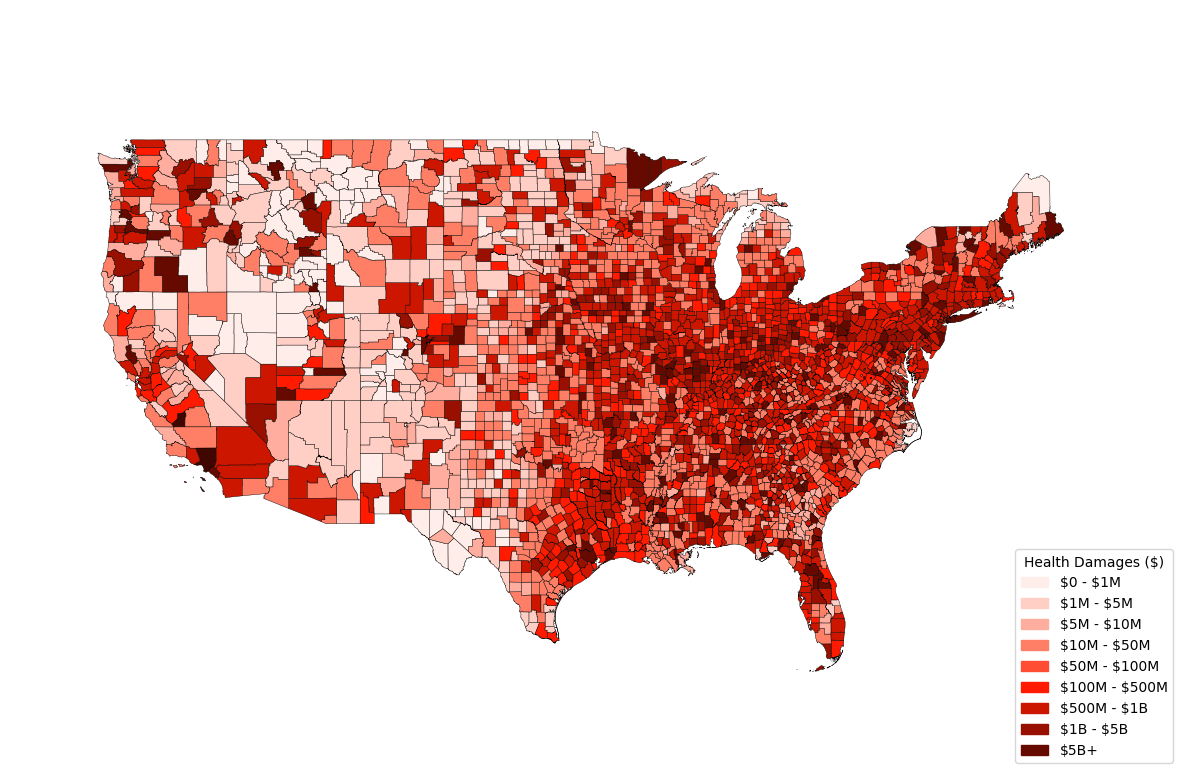

In [113]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.patches as mpatches

# Load the county boundaries shapefile
us_counties = gpd.read_file("../data/raw/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

# Convert counties to match emissions data CRS
us_counties = us_counties.to_crs(resultsISRM.crs)

# Perform spatial join to assign each grid cell to a county
results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")

# Aggregate emissions and health impacts by county
county_summary = results_county.groupby("NAME").agg({
    "SOA": "sum",
    "pNO3": "sum",
    "pNH4": "sum",
    "pSO4": "sum",
    "PrimaryPM25": "sum",
    "TotalPM25": "sum",
    "deathsK": "sum",
    "deathsL": "sum"
}).reset_index()

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico using STATEFP codes
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# Calculate health damages for each county
VSL = 13.2e6  # Value of a Statistical Life in dollars
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL

# Handle NaN values
us_counties.loc[:, 'HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# Define 9 custom bins (0-1M, 1-5M, 5-10M, ..., 5B+)
bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 5e9, float("inf")]  # 10 values → 9 bins
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', 
          '#ff1a00', '#cc1600', '#990f00', '#660a00', '#400600']  # 9 colors

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Bin the data and create a categorical column
us_counties['HealthDamages_Binned'] = pd.cut(us_counties['HealthDamages'], bins=bins, labels=False, include_lowest=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjusted size

# Plot the counties using the binned column
us_counties.plot(column='HealthDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax, legend=False)

# Remove axis labels
ax.axis('off')

# Set the title
plt.title("")

# Set aspect ratio to fix map distortion
ax.set_aspect(1.3)  # Prevents stretching

# Set limits to properly zoom into the contiguous U.S.
ax.set_xlim(-130, -60)  # Longitude limits
ax.set_ylim(20, 55)  # Latitude limits

# Create formatted legend labels (escaping $ sign)
# Create formatted legend labels (properly escaping $ sign)
legend_labels = [
    r"\$0 - \$1M", 
    r"\$1M - \$5M", 
    r"\$5M - \$10M", 
    r"\$10M - \$50M", 
    r"\$50M - \$100M", 
    r"\$100M - \$500M", 
    r"\$500M - \$1B", 
    r"\$1B - \$5B", 
    r"\$5B+"
]

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=legend_labels[i]) 
    for i in range(len(legend_labels))
]

# Add the custom legend to the plot
ax.legend(handles=legend_patches, title="Health Damages ($)", loc="lower right")

# Adjust layout to minimize whitespace
plt.tight_layout()

# Show plot
plt.show()